In [2]:
import torch
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
import csv
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
# from models.convae import ConvAE
import shutil
import random
import itertools
from torchmetrics.functional import structural_similarity_index_measure
from utl.functions import *
# from utils.datasets import 
warnings.filterwarnings('ignore')
%matplotlib inline



Fs = 500
device = get_device()

In [3]:
# # 30 sec ws, 10 sec offset, as it is
# generate_patched_tensors_from_csv('data_csv/','data_WS=30_OF=10/', Fs, 30, 10, 128, 128, db = False)

In [4]:
# # 30 sec ws, 10 sec offset, as it is
# generate_patched_tensors_from_csv('data_csv/','data_WS=30_OF=0/', Fs, 30, 0, 128, 128, db = False)

In [5]:
# # 30 sec ws, 10 sec offset, db
# generate_patched_tensors_from_csv('data_csv/','data_WS=30_OF=10_dB/', Fs, 30, 10, 128, 128, db = True)

In [6]:
# # 30 sec ws, 10 sec offset, db
# generate_patched_tensors_from_csv('data_csv/','data_WS=30_OF=0_dB/', Fs, 30, 0, 128, 128, db = True)

In [7]:
def group_by_recordings(path_to_patches, path_to_save):
    if not os.path.exists(path_to_save):
        os.mkdir(path_to_save)
    for cls in os.listdir(path_to_patches):
        for recording_name in os.listdir(path_to_patches + f'{cls}/'):
            name = recording_name.split('_')[0]
            if not os.path.isdir(path_to_save + f'{cls}/'):
                os.mkdir(path_to_save + f'{cls}/')
            if not os.path.isdir(path_to_save + f'{cls}/' + name):
                os.mkdir(path_to_save + f'{cls}/' + name)
            shutil.copyfile(path_to_patches + f'{cls}/' + recording_name, 
                            path_to_save + f'{cls}/' + name + '/' + recording_name)

def get_random_samples(names, seed, fraction):
    random.seed(seed)
    f_names = [elem for elem in names if elem[0] == 'F']
    s_names = [elem for elem in names if elem[0] == 'S']
    m_names = [elem for elem in names if elem[0] == 'M']
    data = [f_names, s_names, m_names]
    result = []
    for seq in data:
        result.append(random.choices(seq, k = int(fraction * len(seq))))
    return list(itertools.chain(*result))

def train_val_split(path_to_patches, path_to_dataset):
    if not os.path.exists(path_to_dataset):
        os.mkdir(path_to_dataset)
    try:
        for cls in os.listdir(path_to_patches):
            for folder in os.listdir(path_to_patches + f'{cls}/'):
                if folder in health_val or folder in mdd_val:
                    shutil.copytree(path_to_patches + f'{cls}/' + folder, 
                                    path_to_dataset + f'validate/{cls}/' + folder)
                else:
                    shutil.copytree(path_to_patches + f'{cls}/' + folder, 
                                    path_to_dataset + f'train/{cls}/' + folder)
    except:
        pass
                
def mover(path_to_data):
    for phase in os.listdir(path_to_data):
        for cls in os.listdir(path_to_data + phase):
            for folder in os.listdir(path_to_data + phase + f'/{cls}/'):
                for file in os.listdir(path_to_data + phase + f'/{cls}/' + folder):
                    shutil.move(path_to_data + phase + f'/{cls}/' + folder + '/' + file, 
                                path_to_data + phase + f'/{cls}/' + file)
                os.rmdir(path_to_data + phase + f'/{cls}/' + folder)

In [8]:
# group_by_recordings('data_WS=30_OF=10/', 'data_WS=30_OF=10_grouped/')
# mdd_val = get_random_samples(os.listdir('data_WS=30_OF=10_grouped/MDD/'), 42, 0.2)
# health_val = get_random_samples(os.listdir('data_WS=30_OF=10_grouped/Health/'), 42, 0.2)
# train_val_split('data_WS=30_OF=10_grouped/', 'dataset_data_WS=30_OF=10_grouped/')
# mover('dataset_data_WS=30_OF=10_grouped/')

In [9]:
# group_by_recordings('data_WS=30_OF=10_dB/', 'data_WS=30_OF=10_dB_grouped/')
# mdd_val = get_random_samples(os.listdir('data_WS=30_OF=10_dB_grouped/MDD/'), 42, 0.2)
# health_val = get_random_samples(os.listdir('data_WS=30_OF=10_dB_grouped/Health/'), 42, 0.2)
# train_val_split('data_WS=30_OF=10_dB_grouped/', 'dataset_data_WS=30_OF=10_dB_grouped/')
# mover('dataset_data_WS=30_OF=10_dB_grouped/')

In [10]:
# group_by_recordings('data_WS=30_OF=0/', 'data_WS=30_OF=0_grouped/')
# mdd_val = get_random_samples(os.listdir('data_WS=30_OF=0_grouped/MDD/'), 42, 0.2)
# health_val = get_random_samples(os.listdir('data_WS=30_OF=0_grouped/Health/'), 42, 0.2)
# train_val_split('data_WS=30_OF=0_grouped/', 'dataset_data_WS=30_OF=0_grouped/')
# mover('dataset_data_WS=30_OF=0_grouped/')

In [11]:
# group_by_recordings('data_WS=30_OF=0_dB/', 'data_WS=30_OF=0_dB_grouped/')
# mdd_val = get_random_samples(os.listdir('data_WS=30_OF=0_dB_grouped/MDD/'), 42, 0.2)
# health_val = get_random_samples(os.listdir('data_WS=30_OF=0_dB_grouped/Health/'), 42, 0.2)
# train_val_split('data_WS=30_OF=0_dB_grouped/', 'dataset_data_WS=30_OF=0_dB_grouped/')
# mover('dataset_data_WS=30_OF=0_dB_grouped/')

In [12]:
class EegSpec(Dataset):
    def __init__(self,
                 phase: str,
                 data_path: str = 'data'):
        self.images = []
        self.labels = []
        # 1 is MDD, 0 is Health
        for cls in os.listdir(f'{data_path}/{phase}'):
            for file in os.listdir(f'{data_path}/{phase}/' + f'{cls}/'):
                self.images.append(torch.load(f'{data_path}/{phase}/{cls}/' + file))
                self.labels.append(1) if cls == 'MDD' else self.labels.append(0)
#         for file in os.listdir(f'{data_path}/{phase}'):
#             self.images.append(torch.load(f'{data_path}/{phase}/' + file))
                         
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
#         return self.images[idx]  

In [13]:
import torch
from torch import nn


class EncoderBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(EncoderBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels = channels_in, 
                      out_channels = channels_out, 
                      stride = 1, 
                      padding = 2, 
                      kernel_size = 5),
            nn.ReLU(),
            nn.InstanceNorm2d(num_features = channels_out))
        self.dropout = nn.Dropout(0.25)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, padding = 0, stride = 2)
    def forward(self, inputs):
        out = self.layer(inputs)
        out = self.dropout(out)
        out = self.maxpool(out)
        return out
    
    
class DecoderBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels = channels_in,
                                            out_channels = channels_in,
                                            kernel_size = 3,
                                            stride = 2,
                                            padding = 1,
                                            output_padding = 1)
        self.layer = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels = channels_in, 
                          out_channels = channels_out, 
                          stride = 1, 
                          padding = 1, 
                          kernel_size = 3),
            nn.InstanceNorm2d(num_features = channels_out))
        self.dropout = nn.Dropout(0.25)
    def forward(self, inputs):
        out = self.upsample(inputs)
        out = self.layer(out)
        out = self.dropout(out)
        return out

class ConvAE(nn.Module):
    def __init__(self, num_enc_blocks = 4, input_channels = 21):
        super(ConvAE, self).__init__()
        self.encoder_block = nn.ModuleList()
        self.decoder_block = nn.ModuleList()
        channels_in_encoder = []
        channels_out_encoder = []
        channels_in_decoder = []
        channels_out_decoder = []
        for i in range(num_enc_blocks):
            channels_in_encoder.append(2 ** i * input_channels)
            channels_out_encoder.append(2 ** (i + 1) *  input_channels)
        channels_in_decoder = channels_out_encoder[::-1]
        channels_out_decoder = channels_in_encoder[::-1]
        for i in range(num_enc_blocks):
            self.encoder_block.append(EncoderBlock(channels_in_encoder[i],
                                                   channels_out_encoder[i]))
            self.decoder_block.append(DecoderBlock(channels_in_decoder[i],
                                                   channels_out_decoder[i]))
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2))
        
        self.max_pool_spatial = nn.MaxPool2d(kernel_size = 2, padding = 0, stride = 2)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        x = inputs
        for block in self.encoder_block:
            x = block(x)
        # vector in z-space
        lattent_space = x.clone().detach()
        batch_size = lattent_space.shape[0]
#         lattent_space = self.max_pool_spatial(lattent_space)
        lattent_space_mean = torch.mean(lattent_space, dim = 1)
        lattent_space_max = torch.max(lattent_space, dim = 1)[0]
        lattent_space_mean = torch.flatten(lattent_space_mean)
        lattent_space_mean = lattent_space_mean.reshape(batch_size, -1)
        lattent_space_max = torch.flatten(lattent_space_max)
        lattent_space_max = lattent_space_max.reshape(batch_size, -1)
        vectorized_lattent_space = torch.cat([lattent_space_mean, lattent_space_max], dim = 1)
#         print(vectorized_lattent_space.shape)
        label = self.classifier(vectorized_lattent_space)
        
        for block in self.decoder_block:
            x = block(x)
            
        x = self.sigmoid(x)
        return x, label

In [14]:
def compute_accuracy(logits, y_true, device = device):
    y_pred = torch.argmax(logits, dim = 1)
    y_true_on_device = y_true.to(device)
    accuracy = (y_pred == y_true_on_device).float().mean()
    return accuracy

In [15]:
def train(model, epoches, train_dataloader, validation_dataloader, 
          device, criterion_rec, criterion_class, model_name, beta = 1):
    model = model.to(device)
    writer = SummaryWriter(f'runs/{model_name}')
    min_val_loss = np.inf
    for epoch in range(epoches):
        model.train()
        train_loss = 0
        train_accuracy = 0
        train_ssim = 0
        for img, labels in train_dataloader:
            img = img.to(device, dtype = torch.float)
            labels = labels.to(device)
#             output = model(img)
            output = model(img)[0]
            output_logits = model(img)[1]
            loss =  criterion_rec(output, img)  + beta * criterion_class(output_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += compute_accuracy(output_logits, labels)
            train_ssim += structural_similarity_index_measure(output, img).item()
        train_ssim = train_ssim / len(train_dataloader)
        train_loss = train_loss / len(train_dataloader)
        train_accuracy = train_accuracy / len(train_dataloader)

        model.eval() 
        val_loss = 0
        val_accuracy = 0
        val_ssim = 0
        with torch.no_grad():
            for img, labels in validation_dataloader:
                img = img.to(device, dtype = torch.float)
                labels = labels.to(device)
#                 output = model(img)
                output = model(img)[0]
                output_logits = model(img)[1]
                val_loss = criterion_rec(output, img) + beta * criterion_class(output_logits, labels)
                val_loss += val_loss.item()
                val_accuracy += compute_accuracy(output_logits, labels)
#                 print(ssim_v(output, img).item())
                val_ssim += structural_similarity_index_measure(output, img).item()
            val_sim = val_ssim / len(validation_dataloader)
            val_loss = val_loss / len(validation_dataloader)
            val_accuracy = val_accuracy / len(validation_dataloader)
            
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('SSIM/train', train_ssim, epoch)
        writer.add_scalar('SSIM/val', val_ssim, epoch)


        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(),f'best_val_loss_weights_{model_name}.pth')
        print(f'epoch {epoch}/{epoches}\n train loss: {train_loss}\n validation_loss {val_loss}')
        print(f'train ssim: {train_ssim}\n val_ssim {val_ssim}')
        print(f'train accuracy: {train_accuracy}\n val accuracy: {val_accuracy}')

# data_WS=30_OF=10

In [16]:
BATCH = 32
epoches = 200
train_data = EegSpec(data_path = 'dataset_data_WS=30_OF=10_grouped/', phase = 'train')
validate_data = EegSpec(data_path = 'dataset_data_WS=30_OF=10_grouped/', phase = 'validate')
train_dataloader = DataLoader(train_data, batch_size = BATCH, 
                              shuffle = True, num_workers = 10) 
validation_dataloader = DataLoader(validate_data, batch_size = BATCH, 
                                   shuffle = False, num_workers = 10)
model = ConvAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion_rec = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()

In [17]:
train(model, epoches, train_dataloader, validation_dataloader, device, criterion_rec, criterion_class, 'WS=30_OF=10_beta=1')


epoch 0/200
 train loss: 0.9307704504047122
 validation_loss 0.2452634871006012
train ssim: 0.006669302597791622
 val_ssim 0.10188372433185577
train accuracy: 0.4810267984867096
 val accuracy: 0.535714328289032
epoch 1/200
 train loss: 0.9171158203056881
 validation_loss 0.2888953387737274
train ssim: 0.008636246551759541
 val_ssim 0.11103761661797762
train accuracy: 0.5055803656578064
 val accuracy: 0.4821428656578064
epoch 2/200
 train loss: 0.9107575012104852
 validation_loss 0.23904553055763245
train ssim: 0.009238215928365077
 val_ssim 0.1117784408852458
train accuracy: 0.5245535969734192
 val accuracy: 0.53125
epoch 3/200
 train loss: 0.9116569800036294
 validation_loss 0.2596268355846405
train ssim: 0.00930881967568504
 val_ssim 0.1121114669367671
train accuracy: 0.5345982313156128
 val accuracy: 0.4464285969734192
epoch 4/200
 train loss: 0.921539266194616
 validation_loss 0.2184363752603531
train ssim: 0.009163028643732625
 val_ssim 0.10968367848545313
train accuracy: 0.520089

epoch 39/200
 train loss: 0.8878578969410488
 validation_loss 0.2743639647960663
train ssim: 0.012212549236470036
 val_ssim 0.13490515388548374
train accuracy: 0.5870535969734192
 val accuracy: 0.4330357313156128
epoch 40/200
 train loss: 0.8845754734107426
 validation_loss 0.295404314994812
train ssim: 0.012345079399113144
 val_ssim 0.12810126319527626
train accuracy: 0.5859375
 val accuracy: 0.4776785969734192
epoch 41/200
 train loss: 0.8906721302441188
 validation_loss 0.2845044732093811
train ssim: 0.012141175135704023
 val_ssim 0.13034928310662508
train accuracy: 0.59375
 val accuracy: 0.4687500298023224
epoch 42/200
 train loss: 0.8822086559874671
 validation_loss 0.30595695972442627
train ssim: 0.011960231000557542
 val_ssim 0.12760031688958406
train accuracy: 0.5870535969734192
 val accuracy: 0.4598214626312256
epoch 43/200
 train loss: 0.8822623384850365
 validation_loss 0.2842201292514801
train ssim: 0.012018200608768634
 val_ssim 0.12823518738150597
train accuracy: 0.603794

epoch 79/200
 train loss: 0.8809209998164859
 validation_loss 0.32530373334884644
train ssim: 0.011237189938713397
 val_ssim 0.1302648913115263
train accuracy: 0.590401828289032
 val accuracy: 0.3794642984867096
epoch 80/200
 train loss: 0.8829649197203773
 validation_loss 0.30642396211624146
train ssim: 0.011118312033691577
 val_ssim 0.1309904959052801
train accuracy: 0.598214328289032
 val accuracy: 0.3794642984867096
epoch 81/200
 train loss: 0.8902014600379127
 validation_loss 0.33145686984062195
train ssim: 0.011192087716023837
 val_ssim 0.1333403866738081
train accuracy: 0.5714285969734192
 val accuracy: 0.4107142984867096
epoch 82/200
 train loss: 0.8884802737406322
 validation_loss 0.2845013737678528
train ssim: 0.01125823353816356
 val_ssim 0.13287650793790817
train accuracy: 0.5859375
 val accuracy: 0.4062500298023224
epoch 83/200
 train loss: 0.8841892778873444
 validation_loss 0.28934022784233093
train ssim: 0.011169194443417447
 val_ssim 0.13074266258627176
train accuracy:

epoch 118/200
 train loss: 0.8810118649687085
 validation_loss 0.3193664252758026
train ssim: 0.011598723075751747
 val_ssim 0.13426817767322063
train accuracy: 0.5736607313156128
 val accuracy: 0.3705357313156128
epoch 119/200
 train loss: 0.8820410030228751
 validation_loss 0.3205319046974182
train ssim: 0.011630698872197951
 val_ssim 0.1311013028025627
train accuracy: 0.6037946939468384
 val accuracy: 0.392857164144516
epoch 120/200
 train loss: 0.8835186064243317
 validation_loss 0.3286941945552826
train ssim: 0.01123513444326818
 val_ssim 0.13245237432420254
train accuracy: 0.5993303656578064
 val accuracy: 0.4107142984867096
epoch 121/200
 train loss: 0.8850495943001339
 validation_loss 0.3124135136604309
train ssim: 0.011297200107946992
 val_ssim 0.12831080332398415
train accuracy: 0.5837053656578064
 val accuracy: 0.3973214328289032
epoch 122/200
 train loss: 0.8889433443546295
 validation_loss 0.3145591914653778
train ssim: 0.011449371032150728
 val_ssim 0.13041098974645138
tr

epoch 157/200
 train loss: 0.8700544323240008
 validation_loss 0.3248611390590668
train ssim: 0.011153656157798
 val_ssim 0.13256878033280373
train accuracy: 0.6071428656578064
 val accuracy: 0.4062500298023224
epoch 158/200
 train loss: 0.8765270795140948
 validation_loss 0.26221761107444763
train ssim: 0.011426525290257164
 val_ssim 0.1305122198536992
train accuracy: 0.5870535969734192
 val accuracy: 0.4375000298023224
epoch 159/200
 train loss: 0.8753052353858948
 validation_loss 0.26333245635032654
train ssim: 0.011221089067735843
 val_ssim 0.13182380609214306
train accuracy: 0.6071428656578064
 val accuracy: 0.4598214626312256
epoch 160/200
 train loss: 0.8748212627002171
 validation_loss 0.24771353602409363
train ssim: 0.011561322092477764
 val_ssim 0.13505026511847973
train accuracy: 0.6104910969734192
 val accuracy: 0.4776785969734192
epoch 161/200
 train loss: 0.8726208997624261
 validation_loss 0.25235292315483093
train ssim: 0.011683505361101456
 val_ssim 0.13272413611412048

epoch 196/200
 train loss: 0.8721102539982114
 validation_loss 0.26208484172821045
train ssim: 0.011232951223584158
 val_ssim 0.12939255125820637
train accuracy: 0.6227678656578064
 val accuracy: 0.4285714626312256
epoch 197/200
 train loss: 0.8674373200961522
 validation_loss 0.24822880327701569
train ssim: 0.011326928922374333
 val_ssim 0.13239198923110962
train accuracy: 0.6160714626312256
 val accuracy: 0.4642857313156128
epoch 198/200
 train loss: 0.8665873727628163
 validation_loss 0.2685704529285431
train ssim: 0.011589440783219678
 val_ssim 0.13148553390055895
train accuracy: 0.6205357313156128
 val accuracy: 0.4107142984867096
epoch 199/200
 train loss: 0.8675726503133774
 validation_loss 0.2623378038406372
train ssim: 0.011373122522075261
 val_ssim 0.1303352303802967
train accuracy: 0.6227678656578064
 val accuracy: 0.4285714626312256


# data_WS=30_OF=0 

In [18]:
BATCH = 32
epoches = 200
train_data = EegSpec(data_path = 'dataset_data_WS=30_OF=0_grouped/', phase = 'train')
validate_data = EegSpec(data_path = 'dataset_data_WS=30_OF=0_grouped/', phase = 'validate')
train_dataloader = DataLoader(train_data, batch_size = BATCH, 
                              shuffle = True, num_workers = 10) 
validation_dataloader = DataLoader(validate_data, batch_size = BATCH, 
                                   shuffle = False, num_workers = 10)
model = ConvAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion_rec = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()

In [19]:
train(model, epoches, train_dataloader, validation_dataloader, device, criterion_rec, criterion_class, 'WS=30_OF=0_beta=1')


epoch 0/200
 train loss: 0.7618178178866705
 validation_loss 0.46802979707717896
train ssim: 0.2498143642830352
 val_ssim 1.0953914821147919
train accuracy: 0.49270832538604736
 val accuracy: 0.53125
epoch 1/200
 train loss: 0.7404149075349172
 validation_loss 0.4847734868526459
train ssim: 0.18522745122512183
 val_ssim 0.9541363716125488
train accuracy: 0.46406251192092896
 val accuracy: 0.4490740895271301
epoch 2/200
 train loss: 0.7241895248492559
 validation_loss 0.41688451170921326
train ssim: 0.14228029921650887
 val_ssim 1.2927217185497284
train accuracy: 0.5145833492279053
 val accuracy: 0.53125
epoch 3/200
 train loss: 0.7238209694623947
 validation_loss 0.41093993186950684
train ssim: 0.17594305922587714
 val_ssim 1.462668627500534
train accuracy: 0.4854166507720947
 val accuracy: 0.53125
epoch 4/200
 train loss: 0.7172127614418665
 validation_loss 0.44863709807395935
train ssim: 0.18997939179340997
 val_ssim 1.4297015070915222
train accuracy: 0.5260416865348816
 val accuracy

epoch 41/200
 train loss: 0.6828381369511286
 validation_loss 0.3769077658653259
train ssim: 0.22581648329893747
 val_ssim 1.7905957698822021
train accuracy: 0.6088541746139526
 val accuracy: 0.53125
epoch 42/200
 train loss: 0.684596930940946
 validation_loss 0.3374437987804413
train ssim: 0.22622903684775034
 val_ssim 1.7865897417068481
train accuracy: 0.5614583492279053
 val accuracy: 0.53125
epoch 43/200
 train loss: 0.6919882893562317
 validation_loss 0.38256263732910156
train ssim: 0.225806908061107
 val_ssim 1.7834005951881409
train accuracy: 0.5828125476837158
 val accuracy: 0.53125
epoch 44/200
 train loss: 0.6992888748645782
 validation_loss 0.3991611897945404
train ssim: 0.22640095899502435
 val_ssim 1.790931761264801
train accuracy: 0.5484375357627869
 val accuracy: 0.5520833730697632
epoch 45/200
 train loss: 0.6835127721230189
 validation_loss 0.3436538875102997
train ssim: 0.22699605549375215
 val_ssim 1.796012043952942
train accuracy: 0.5541666746139526
 val accuracy: 0

epoch 82/200
 train loss: 0.6444477885961533
 validation_loss 0.26512446999549866
train ssim: 0.22744822377959886
 val_ssim 1.802180290222168
train accuracy: 0.6395833492279053
 val accuracy: 0.53125
epoch 83/200
 train loss: 0.631413996219635
 validation_loss 0.23547808825969696
train ssim: 0.22807468473911285
 val_ssim 1.80380517244339
train accuracy: 0.6442708373069763
 val accuracy: 0.53125
epoch 84/200
 train loss: 0.6424394895633062
 validation_loss 0.24923209846019745
train ssim: 0.22820032884677252
 val_ssim 1.8058300614356995
train accuracy: 0.6635416746139526
 val accuracy: 0.53125
epoch 85/200
 train loss: 0.627244288722674
 validation_loss 0.2974171042442322
train ssim: 0.22825982049107552
 val_ssim 1.8101701140403748
train accuracy: 0.6609375476837158
 val accuracy: 0.5416666865348816
epoch 86/200
 train loss: 0.655190701285998
 validation_loss 0.32864516973495483
train ssim: 0.2287718914449215
 val_ssim 1.8094353675842285
train accuracy: 0.6223958730697632
 val accuracy: 

epoch 123/200
 train loss: 0.6469794909159342
 validation_loss 0.3336382806301117
train ssim: 0.231413750598828
 val_ssim 1.8138247728347778
train accuracy: 0.6500000357627869
 val accuracy: 0.5127314925193787
epoch 124/200
 train loss: 0.6729475557804108
 validation_loss 0.38873571157455444
train ssim: 0.2308154503504435
 val_ssim 1.8265411853790283
train accuracy: 0.6177083253860474
 val accuracy: 0.5173611044883728
epoch 125/200
 train loss: 0.6721041798591614
 validation_loss 0.36550045013427734
train ssim: 0.23133929322163263
 val_ssim 1.8290554881095886
train accuracy: 0.5963541865348816
 val accuracy: 0.49421295523643494
epoch 126/200
 train loss: 0.6875573595364889
 validation_loss 0.3328897953033447
train ssim: 0.23098233342170715
 val_ssim 1.8256602883338928
train accuracy: 0.5885416865348816
 val accuracy: 0.53125
epoch 127/200
 train loss: 0.699696883559227
 validation_loss 0.422718346118927
train ssim: 0.2318691834807396
 val_ssim 1.8326790928840637
train accuracy: 0.55052

epoch 163/200
 train loss: 0.6658744017283121
 validation_loss 0.336365282535553
train ssim: 0.23494992280999819
 val_ssim 1.8549655675888062
train accuracy: 0.6145833730697632
 val accuracy: 0.5254629850387573
epoch 164/200
 train loss: 0.6431132654349009
 validation_loss 0.3343038558959961
train ssim: 0.23433435708284378
 val_ssim 1.8514851331710815
train accuracy: 0.6651041507720947
 val accuracy: 0.5625
epoch 165/200
 train loss: 0.6440373758474985
 validation_loss 0.35118553042411804
train ssim: 0.23477287466327348
 val_ssim 1.8513396382331848
train accuracy: 0.6369792222976685
 val accuracy: 0.5046296119689941
epoch 166/200
 train loss: 0.6431014935175577
 validation_loss 0.30894410610198975
train ssim: 0.23466592157880464
 val_ssim 1.8508056998252869
train accuracy: 0.6385416984558105
 val accuracy: 0.5520833730697632
epoch 167/200
 train loss: 0.6550844808419546
 validation_loss 0.299752414226532
train ssim: 0.23351233204205832
 val_ssim 1.8472237586975098
train accuracy: 0.634

# data_WS=30_OF=10 dB

In [16]:
BATCH = 32
epoches = 200
train_data = EegSpec(data_path = 'dataset_data_WS=30_OF=10_dB_grouped/', phase = 'train')
validate_data = EegSpec(data_path = 'dataset_data_WS=30_OF=10_dB_grouped/', phase = 'validate')
train_dataloader = DataLoader(train_data, batch_size = BATCH, 
                              shuffle = True, num_workers = 10) 
validation_dataloader = DataLoader(validate_data, batch_size = BATCH, 
                                   shuffle = False, num_workers = 10)
model = ConvAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion_rec = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()

In [17]:
train(model, epoches, train_dataloader, validation_dataloader, device, criterion_rec, criterion_class, 'WS=30_OF=10_dB_beta=1')


epoch 0/200
 train loss: 0.7530830012900489
 validation_loss 0.21736958622932434
train ssim: 0.26543976958574994
 val_ssim 3.111630469560623
train accuracy: 0.494419664144516
 val accuracy: 0.4687500298023224
epoch 1/200
 train loss: 0.7207725431237902
 validation_loss 0.2589253783226013
train ssim: 0.19413417684180395
 val_ssim 3.9303858876228333
train accuracy: 0.512276828289032
 val accuracy: 0.4687500298023224
epoch 2/200
 train loss: 0.7163364929812295
 validation_loss 0.2416413575410843
train ssim: 0.21775811218789645
 val_ssim 4.12199592590332
train accuracy: 0.5078125
 val accuracy: 0.4687500298023224
epoch 3/200
 train loss: 0.718430893761771
 validation_loss 0.2265758514404297
train ssim: 0.2211250944861344
 val_ssim 4.192789614200592
train accuracy: 0.5111607313156128
 val accuracy: 0.4687500298023224
epoch 4/200
 train loss: 0.7152689120599202
 validation_loss 0.21381981670856476
train ssim: 0.223166823387146
 val_ssim 4.2074973583221436
train accuracy: 0.4832589626312256
 

epoch 40/200
 train loss: 0.6969557085207531
 validation_loss 0.1872195303440094
train ssim: 0.23112515679427556
 val_ssim 4.307424008846283
train accuracy: 0.5502232313156128
 val accuracy: 0.566964328289032
epoch 41/200
 train loss: 0.6879190845148904
 validation_loss 0.20810221135616302
train ssim: 0.23103815423590796
 val_ssim 4.292923390865326
train accuracy: 0.5770089626312256
 val accuracy: 0.5
epoch 42/200
 train loss: 0.6931331817592893
 validation_loss 0.20855404436588287
train ssim: 0.23191563252891814
 val_ssim 4.3189098834991455
train accuracy: 0.5558035969734192
 val accuracy: 0.4642857313156128
epoch 43/200
 train loss: 0.6895699139152255
 validation_loss 0.2076815962791443
train ssim: 0.23206577929002897
 val_ssim 4.311255931854248
train accuracy: 0.566964328289032
 val accuracy: 0.455357164144516
epoch 44/200
 train loss: 0.6948577484914235
 validation_loss 0.19988593459129333
train ssim: 0.2321771824998515
 val_ssim 4.315599799156189
train accuracy: 0.5491071939468384

epoch 80/200
 train loss: 0.6810890798057828
 validation_loss 0.16000434756278992
train ssim: 0.23957272246479988
 val_ssim 4.504023373126984
train accuracy: 0.5892857313156128
 val accuracy: 0.5401785969734192
epoch 81/200
 train loss: 0.6734274263892855
 validation_loss 0.1763097196817398
train ssim: 0.2395089454948902
 val_ssim 4.491284072399139
train accuracy: 0.5837053656578064
 val accuracy: 0.5401785969734192
epoch 82/200
 train loss: 0.6768124720879963
 validation_loss 0.16680611670017242
train ssim: 0.23967904384647096
 val_ssim 4.51500129699707
train accuracy: 0.5703125
 val accuracy: 0.5446428656578064
epoch 83/200
 train loss: 0.6827294315610614
 validation_loss 0.17220525443553925
train ssim: 0.2396527033831392
 val_ssim 4.5218557715415955
train accuracy: 0.5770089626312256
 val accuracy: 0.53125
epoch 84/200
 train loss: 0.6824999238763537
 validation_loss 0.18717212975025177
train ssim: 0.23984248403991973
 val_ssim 4.507851481437683
train accuracy: 0.590401828289032
 va

epoch 120/200
 train loss: 0.6845960255180087
 validation_loss 0.17803283035755157
train ssim: 0.24431707284280232
 val_ssim 4.5888946652412415
train accuracy: 0.5714285969734192
 val accuracy: 0.5491071939468384
epoch 121/200
 train loss: 0.6790349206754139
 validation_loss 0.1634761393070221
train ssim: 0.24436297108020102
 val_ssim 4.5893747210502625
train accuracy: 0.5636160969734192
 val accuracy: 0.535714328289032
epoch 122/200
 train loss: 0.6833449900150299
 validation_loss 0.18574123084545135
train ssim: 0.24399808794260025
 val_ssim 4.596710801124573
train accuracy: 0.574776828289032
 val accuracy: 0.4910714626312256
epoch 123/200
 train loss: 0.6792836316994258
 validation_loss 0.18409429490566254
train ssim: 0.24391793778964452
 val_ssim 4.601202309131622
train accuracy: 0.5770089626312256
 val accuracy: 0.5401785969734192
epoch 124/200
 train loss: 0.6780712498085839
 validation_loss 0.18117688596248627
train ssim: 0.24449722841382027
 val_ssim 4.596933305263519
train accu

epoch 160/200
 train loss: 0.6666217935936791
 validation_loss 0.23990564048290253
train ssim: 0.24905197375587054
 val_ssim 4.671817898750305
train accuracy: 0.5993303656578064
 val accuracy: 0.5267857313156128
epoch 161/200
 train loss: 0.6717053332499096
 validation_loss 0.26800864934921265
train ssim: 0.24895816083465303
 val_ssim 4.663284242153168
train accuracy: 0.5870535969734192
 val accuracy: 0.5446428656578064
epoch 162/200
 train loss: 0.6672924969877515
 validation_loss 0.22635331749916077
train ssim: 0.2490810283592769
 val_ssim 4.650052011013031
train accuracy: 0.606026828289032
 val accuracy: 0.535714328289032
epoch 163/200
 train loss: 0.6702432781457901
 validation_loss 0.20560477674007416
train ssim: 0.24900703132152557
 val_ssim 4.67049366235733
train accuracy: 0.6015625
 val accuracy: 0.5178571939468384
epoch 164/200
 train loss: 0.6756766523633685
 validation_loss 0.18028004467487335
train ssim: 0.249491992273501
 val_ssim 4.682773947715759
train accuracy: 0.584821

# data_WS=30_OF=0 dB

In [18]:
BATCH = 32
epoches = 200
train_data = EegSpec(data_path = 'dataset_data_WS=30_OF=0_dB_grouped/', phase = 'train')
validate_data = EegSpec(data_path = 'dataset_data_WS=30_OF=0_dB_grouped/', phase = 'validate')
train_dataloader = DataLoader(train_data, batch_size = BATCH, 
                              shuffle = True, num_workers = 10) 
validation_dataloader = DataLoader(validate_data, batch_size = BATCH, 
                                   shuffle = False, num_workers = 10)
model = ConvAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion_rec = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()

In [19]:
train(model, epoches, train_dataloader, validation_dataloader, device, criterion_rec, criterion_class, 'WS=30_OF=0_dB_beta=1')
# actually didn't learn

epoch 0/200
 train loss: 0.7635970463355383
 validation_loss 0.5225474834442139
train ssim: 0.31390477747966844
 val_ssim 1.044576495885849
train accuracy: 0.48489582538604736
 val accuracy: 0.46875
epoch 1/200
 train loss: 0.7375538249810537
 validation_loss 0.4807721972465515
train ssim: 0.19770275553067526
 val_ssim 0.9160450994968414
train accuracy: 0.44687503576278687
 val accuracy: 0.5509259700775146
epoch 2/200
 train loss: 0.7179807623227438
 validation_loss 0.5094388723373413
train ssim: 0.17367355898022652
 val_ssim 1.3614610433578491
train accuracy: 0.5406250357627869
 val accuracy: 0.46875
epoch 3/200
 train loss: 0.7218884974718094
 validation_loss 0.5108840465545654
train ssim: 0.19266015539566675
 val_ssim 1.5819151997566223
train accuracy: 0.48854169249534607
 val accuracy: 0.46875
epoch 4/200
 train loss: 0.713761106133461
 validation_loss 0.47858521342277527
train ssim: 0.2020411379635334
 val_ssim 1.6576095223426819
train accuracy: 0.47604167461395264
 val accuracy: 

KeyboardInterrupt: 

# Results

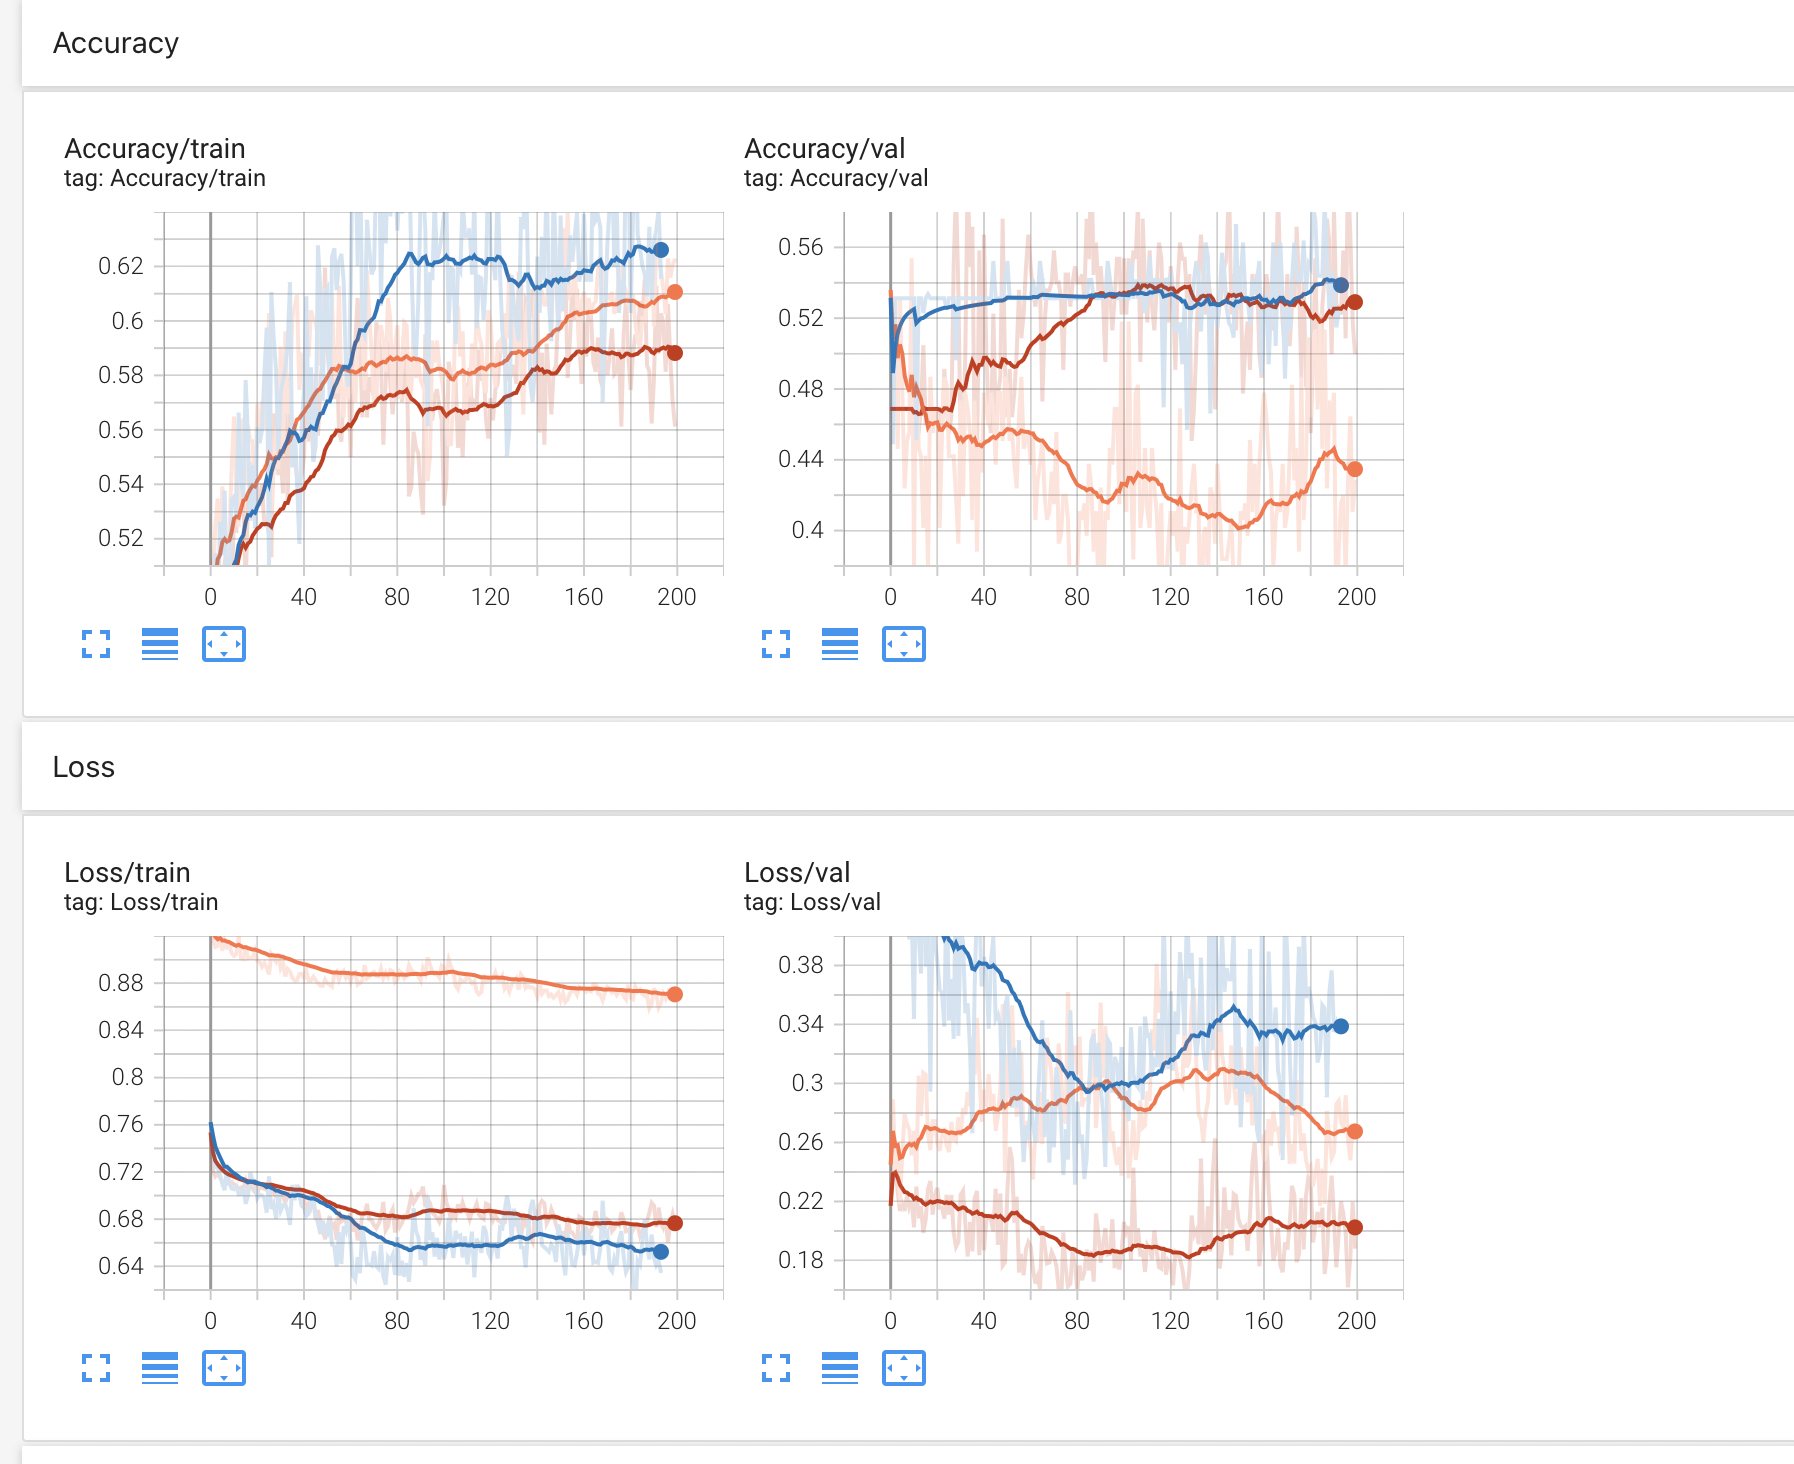

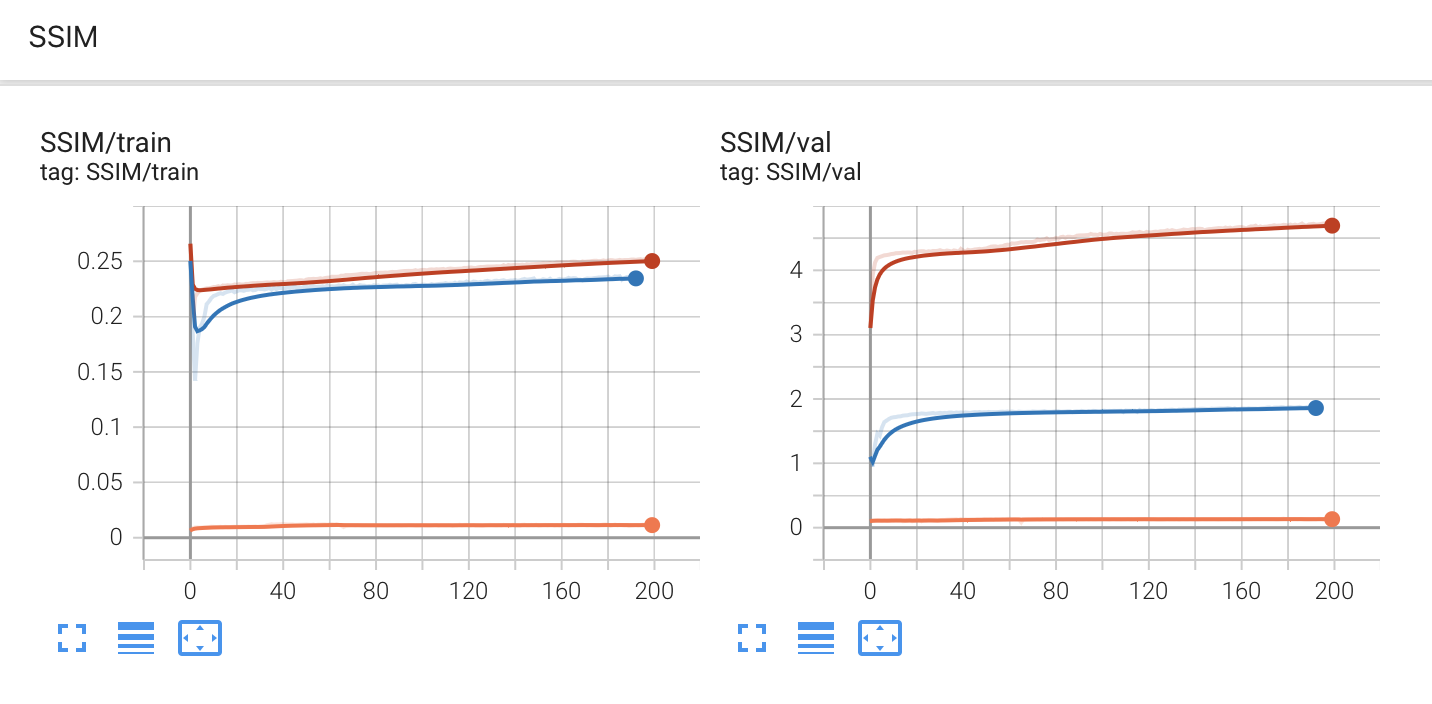